In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import re
import scanpy as sc
from scipy.sparse import csr_matrix
import scvi
import torch
import seaborn as sns

In [3]:
filename = '../data_out/matrix_filtered_stim_after_filtering.h5ad'
adata_stim = sc.read(filename)

In [4]:
filename = '../data_out/matrix_filtered_nostim_after_filtering.h5ad'
adata_nostim = sc.read(filename)

In [6]:
adata = sc.concat([adata_stim, adata_nostim])

In [7]:
sc.pp.filter_genes(adata, min_cells = 10)

In [10]:
type(adata.X)

scipy.sparse._csr.csr_matrix

In [12]:
adata.write_h5ad('../data_out/matrix_combined.h5ad')

In [13]:
sc.pp.filter_genes(adata, min_cells = 100)

In [14]:
adata.layers['counts'] = adata.X.copy()

In [15]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [17]:
torch.set_float32_matmul_precision('medium')
scvi.settings.dl_num_workers = 19
scvi.settings.batch_size = 512


scvi.model.SCVI.setup_anndata(
    adata, layer = "counts",
    categorical_covariate_keys=["condition"],
    continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo']
)

model = scvi.model.SCVI(adata)
model.to_device('cuda')
model.train(batch_size=512)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/153 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=153` reached.


In [18]:
adata.obsm['X_scVI'] = model.get_latent_representation()
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [56]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.8)

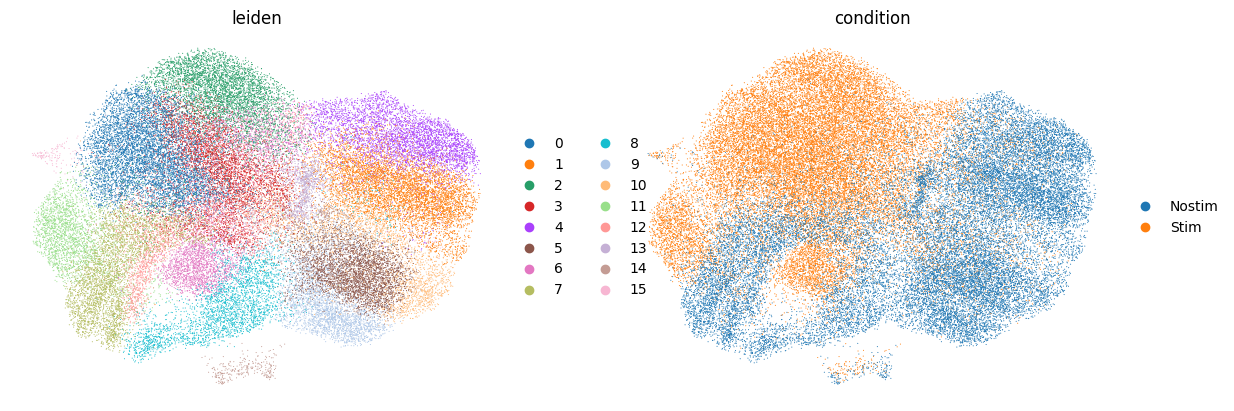

In [57]:
sc.pl.umap(adata, color = ['leiden', 'condition'], frameon = False)

In [58]:
adata.write_h5ad('../data_out/integrated.h5ad')

In [59]:
adata

AnnData object with n_obs × n_vars = 52188 × 15463
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling'
    var: 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'condition_colors', 'rank_genes_groups'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [60]:
sc.tl.rank_genes_groups(adata, 'leiden')

In [63]:
# sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [64]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals < 0.05) & markers.logfoldchanges > 0.5]
markers

group     names      scores  logfoldchanges  pvals  pvals_adj
0          0       PKM  142.052948        1.700415    0.0        0.0
1          0     HSPA8  132.493317        1.296913    0.0        0.0
2          0     IL2RA  126.688660        2.457959    0.0        0.0
3          0      ENO1  126.534470        1.251886    0.0        0.0
4          0  HSP90AB1  124.864716        1.489473    0.0        0.0
...      ...       ...         ...             ...    ...        ...
247403    15   SLC12A9  -67.039864      -26.380156    0.0        0.0
247404    15     GPR18  -67.423691      -26.490294    0.0        0.0
247405    15     ITGA6  -67.508568      -26.685749    0.0        0.0
247406    15   DPY19L4  -68.071785      -26.368704    0.0        0.0
247407    15    LRRCC1  -86.127548      -27.010138    0.0        0.0

[156275 rows x 6 columns]

In [65]:
markers_scvi = model.differential_expression(groupby='leiden')

DE...:   0%|          | 0/16 [00:00<?, ?it/s]

In [66]:
markers_scvi

proba_de  proba_not_de  bayes_factor        scale1    scale2  \
GZMK         0.9682        0.0318      3.415972  4.789609e-06  0.000065   
CCL3         0.9674        0.0326      3.390299  8.079883e-04  0.000553   
CCL4         0.9668        0.0332      3.371441  1.109403e-03  0.000662   
E2F8         0.9666        0.0334      3.365229  2.424003e-05  0.000017   
LINC01727    0.9658        0.0342      3.340731  3.067219e-07  0.000003   
...             ...           ...           ...           ...       ...   
DDX50        0.3388        0.6612     -0.668646  6.443266e-05  0.000067   
PPP6C        0.3296        0.6704     -0.709995  4.482094e-05  0.000044   
PAFAH1B1     0.2842        0.7158     -0.923723  1.820980e-04  0.000168   
SAR1A        0.2768        0.7232     -0.960391  6.157466e-05  0.000060   
PPHLN1       0.2384        0.7616     -1.161472  9.082608e-05  0.000093   

           pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
GZMK                0.0   0.25 -3.472361   -3.834893  2.716808  ...   
CCL3                0.0   0.25  2.857027    3.323721  3.679255  ...   
CCL4                0.0   0.25  2.419883    2.805637  3.328750  ...   
E2F8                0.0   0.25  2.174277    2.514641  3.985815  ...   
LINC01727           0.0   0.25 -2.786621   -3.095986  2.781667  ...   
...                 ...    ...       ...         ...       ...  ...   
DDX50               0.0   0.25 -0.059206   -0.055212  0.257865  ...   
PPP6C               0.0   0.25  0.034935    0.040311  0.257682  ...   
PAFAH1B1            0.0   0.25  0.117092    0.119773  0.194654  ...   
SAR1A               0.0   0.25  0.041779    0.040215  0.233687  ...   
PPHLN1              0.0   0.25 -0.043887   -0.034950  0.208589  ...   

           raw_mean1  raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
GZMK        0.028700   0.284553               0.018648               0.108949   
CCL3        6.516420   4.889397               0.579691               0.235284   
CCL4        9.963387   7.170463               0.579545               0.233475   
E2F8        0.275350   0.208613               0.186043               0.123864   
LINC01727   0.000291   0.007457               0.000291               0.006972   
...              ...        ...                    ...                    ...   
DDX50       0.149485   0.515259               0.139175               0.370216   
PPP6C       0.092784   0.332656               0.061856               0.270666   
PAFAH1B1    0.298969   1.177645               0.206186               0.640324   
SAR1A       0.139175   0.498002               0.087629               0.365042   
PPHLN1      0.144330   0.662408               0.128866               0.457187   

           raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
GZMK                   0.036778              0.487274            True   
CCL3                   9.166856              5.921195            True   
CCL4                  15.940255              9.077095            True   
E2F8                   0.311237              0.216388            True   
LINC01727              0.000678              0.013679            True   
...                         ...                   ...             ...   
DDX50                  0.958576              0.731542           False   
PPP6C                  0.294374              0.486612           False   
PAFAH1B1               1.632807              1.741817           False   
SAR1A                  0.574066              0.716711           False   
PPHLN1                 0.934853              0.985888           False   

           comparison  group1 group2  
GZMK        0 vs Rest       0   Rest  
CCL3        0 vs Rest       0   Rest  
CCL4        0 vs Rest       0   Rest  
E2F8        0 vs Rest       0   Rest  
LINC01727   0 vs Rest       0   Rest  
...               ...     ...    ...  
DDX50      15 vs Rest      15   Rest  
PPP6C      15 vs Rest      15   Rest  
PAFAH1B1   15 vs Rest      15   Rest  
SAR1A      15 vs 

In [67]:
markers_scvi_filtered = markers_scvi[(markers_scvi['is_de_fdr_0.05'] < 0.05) & (markers_scvi.lfc_mean > 0.5)]

In [68]:
markers_scvi_filtered

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
TNFRSF8       0.9424        0.0576      2.794907  0.000033  0.000010   
TCF19         0.9422        0.0578      2.791229  0.000030  0.000013   
AC145207.5    0.9420        0.0580      2.787562  0.000012  0.000004   
NIPAL4        0.9420        0.0580      2.787562  0.000005  0.000002   
KIFC1         0.9418        0.0582      2.783907  0.000029  0.000029   
...              ...           ...           ...       ...       ...   
KCTD18        0.7398        0.2602      1.044929  0.000020  0.000015   
VPS25         0.7372        0.2628      1.031466  0.000054  0.000037   
PPP3CC        0.7336        0.2664      1.012965  0.000028  0.000020   
ELF2          0.7298        0.2702      0.993608  0.000074  0.000053   
GOLPH3L       0.7112        0.2888      0.901219  0.000020  0.000015   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
TNFRSF8              0.0   0.25  2.472174    2.451757  2.057209  ...   
TCF19                0.0   0.25  1.766871    1.955580  2.164270  ...   
AC145207.5           0.0   0.25  1.759317    1.784806  1.103320  ...   
NIPAL4               0.0   0.25  1.974770    2.105505  1.545272  ...   
KIFC1                0.0   0.25  1.139639    1.478817  2.560302  ...   
...                  ...    ...       ...         ...       ...  ...   
KCTD18               0.0   0.25  0.537365    0.486892  0.689246  ...   
VPS25                0.0   0.25  0.502239    0.495941  0.564635  ...   
PPP3CC               0.0   0.25  0.535054    0.475203  0.530438  ...   
ELF2                 0.0   0.25  0.528519    0.483733  0.615036  ...   
GOLPH3L              0.0   0.25  0.510843    0.440593  0.613811  ...   

            raw_mean1  raw_mean2  non_zeros_proportion1  \
TNFRSF8      0.290500   0.080487               0.204400   
TCF19        0.308710   0.152879               0.238782   
AC145207.5   0.101836   0.037089               0.094843   
NIPAL4       0.011509   0.004280               0.010052   
KIFC1        0.280740   0.358574               0.202506   
...               ...        ...                    ...   
KCTD18       0.061856   0.110816               0.061856   
VPS25        0.087629   0.293644               0.056701   
PPP3CC       0.036082   0.162827               0.036082   
ELF2         0.164948   0.384307               0.118557   
GOLPH3L      0.056701   0.115546               0.056701   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
TNFRSF8                  0.062682              0.379659              0.094473   
TCF19                    0.122143              0.403740              0.175914   
AC145207.5               0.035015              0.143505              0.047577   
NIPAL4                   0.003773              0.016646              0.005220   
KIFC1                    0.191576              0.325196              0.372276   
...                           ...                   ...                   ...   
KCTD18                   0.102781              0.428121              0.175906   
VPS25                    0.239066              0.268513              0.403427   
PPP3CC                   0.145613              0.168528              0.249625   
ELF2                     0.302823              0.901138              0.601304   
GOLPH3L                  0.106301              0.245090              0.176349   

            is_de_fdr_0.05  comparison  group1 group2  
TNFRSF8              False   0 vs Rest       0   Rest  
TCF19                False   0 vs Rest       0   Rest  
AC145207.5           False   0 vs Rest       0   Rest  
NIPAL4               False   0 vs Rest       0   Rest  
KIFC1                False   0 vs Rest       0   Rest  
...                    ...         ...     ...    ...  
KCTD18               False  15 vs Rest      15   Rest  
VPS25                False  15 vs Rest      15   Rest  
PPP3CC               False  15 vs Rest      15   Rest  
ELF2                 False  15 vs Rest  

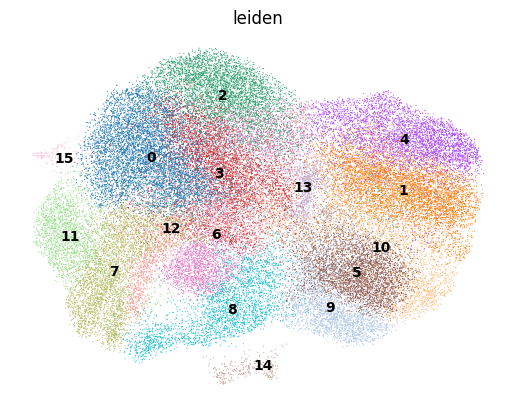

In [69]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

pangodb: https://panglaodb.se/markers.html?cell_type=%27choose%27

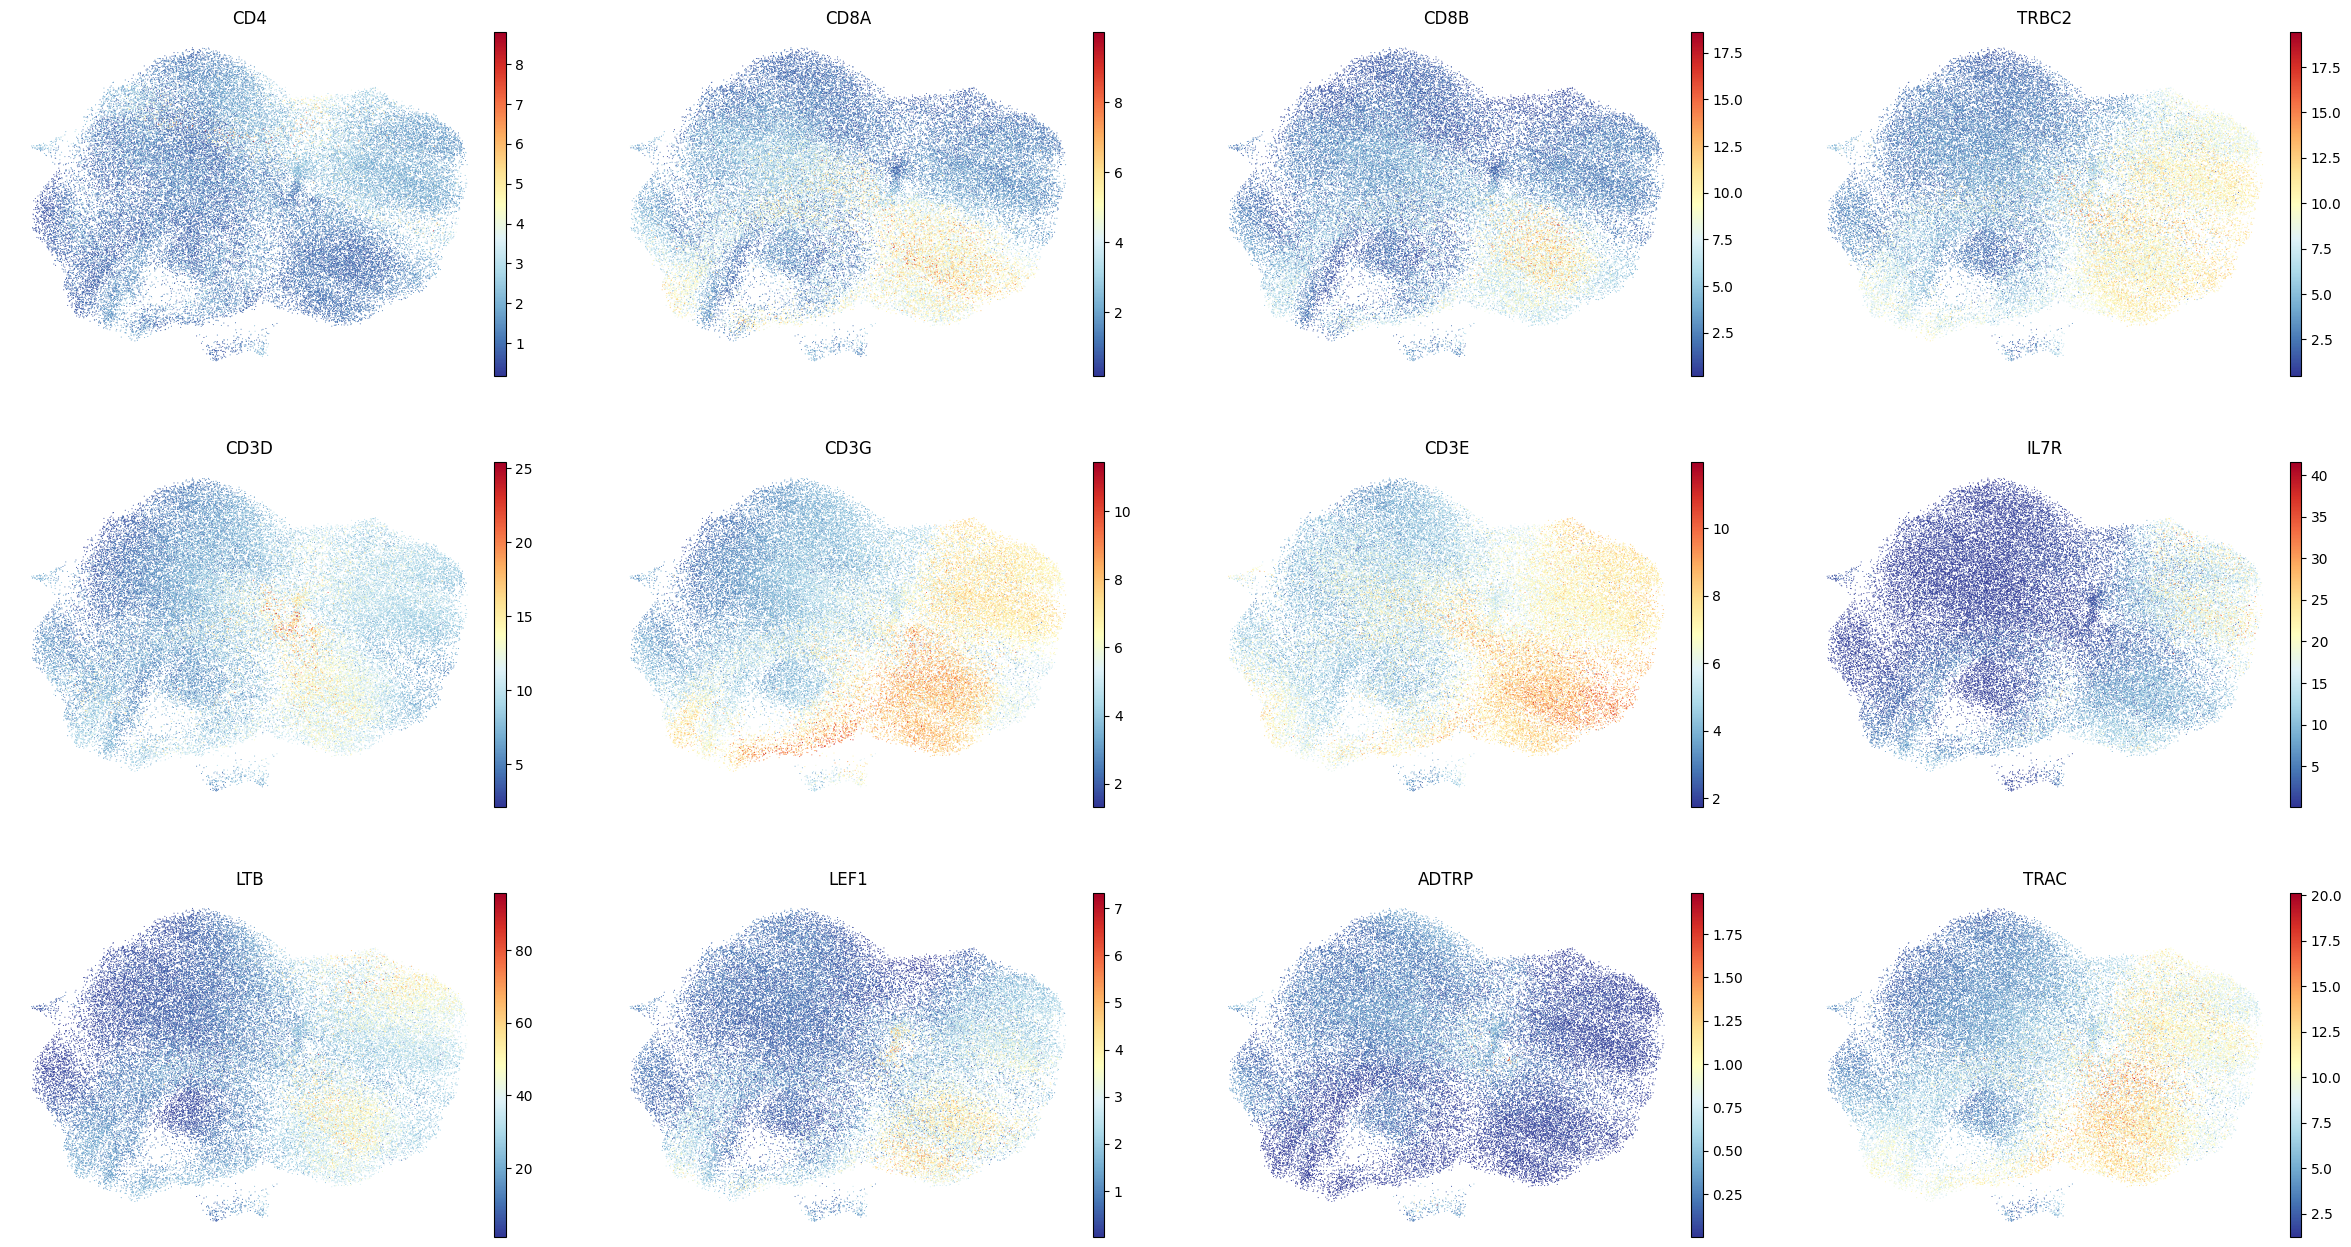

In [115]:
import matplotlib as mpl
sc.pl.umap(
    adata,
    color=['CD4', 'CD8A', 'CD8B', 'TRBC2', 'CD3D', 'CD3G', 'CD3E', 'IL7R', 'LTB', 'LEF1', 'ADTRP', 'TRAC'],
    # color=['CCL4', 'CCL3', 'IFNG', 'CCL4L2'],
    frameon = False,
    layer='scvi_normalized',
    palette="Set2", color_map=mpl.cm.RdYlBu_r
)

In [71]:
{
    "5": "CD8B"
}

{'5': 'CD8B'}

In [113]:
markers[['logfoldchanges', 'group']][markers.names.isin(['CCL4', 'CCL3', 'IFNG', 'CCL4L2'])].groupby('group').sum().sort_values('logfoldchanges', ascending=False)

/tmp/ipykernel_1817562/575841835.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  markers[['logfoldchanges', 'group']][markers.names.isin(['CCL4', 'CCL3', 'IFNG', 'CCL4L2'])].groupby('group').sum().sort_values('logfoldchanges', ascending=False)


logfoldchanges
group                
3            9.688784
11           8.674703
6            6.891067
0            6.377338
15           1.759540
2           -0.144181
10          -5.438739
12          -5.980188
4           -7.350886
13          -7.745819
14          -9.874212
7          -12.111064
5          -12.912344
8          -13.295852
1          -13.390042
9          -15.322783

In [94]:
markers[markers.names == 'CD8B'].sort_values('logfoldchanges', ascending=False)

group names      scores  logfoldchanges          pvals      pvals_adj
77315      5  CD8B   97.567787        2.694631   0.000000e+00   0.000000e+00
139169     9  CD8B   72.906120        2.353776   0.000000e+00   0.000000e+00
46418      3  CD8B   48.180477        1.381046   0.000000e+00   0.000000e+00
154640    10  CD8B   25.426250        1.213040  1.444904e-128  4.674173e-127
108590     7  CD8B   29.960491        1.030209  1.337802e-179  4.458284e-178
217326    14  CD8B    4.471938        0.535814   9.965004e-06   6.937814e-05
125303     8  CD8B    5.902274        0.274538   3.949859e-09   1.595524e-08
11562      0  CD8B   -3.610584       -0.103448   3.069758e-04   5.041707e-04
184292    11  CD8B   -7.832806       -0.348230   6.866686e-15   2.535329e-14
215369    13  CD8B   -6.012191       -0.388959   2.295051e-09   1.799613e-08
108137     6  CD8B  -40.702816       -1.493234   0.000000e+00   0.000000e+00
244072    15  CD8B   -9.521024       -2.021971   6.798055e-18   3.134118e-17
46388      2  CD8B -107.836990       -3.635029   0.000000e+00   0.000000e+00
201018    12  CD8B  -84.775719       -3.695811   0.000000e+00   0.000000e+00
30922      1  CD8B -118.893402       -3.858426   0.000000e+00   0.000000e+00
77309      4  CD8B -104.789001       -3.869271   0.000000e+00   0.000000e+00

In [103]:
markers_scvi_filtered[markers_scvi_filtered['group1']=='14'].sort_values('lfc_mean', ascending=False)

proba_de  proba_not_de  bayes_factor        scale1        scale2  \
ADTRP       0.9342        0.0658      2.653071  4.713042e-05  1.514200e-05   
TNNC2       0.9338        0.0662      2.646582  1.094924e-05  2.239311e-06   
LGALS9      0.9342        0.0658      2.653071  7.719207e-05  1.895278e-05   
SERP2       0.9354        0.0646      2.672760  4.677006e-06  1.212744e-06   
SMARCA2     0.9310        0.0690      2.602153  3.709953e-04  9.059049e-05   
...            ...           ...           ...           ...           ...   
VCAM1       0.9164        0.0836      2.394409  3.124745e-06  3.306926e-06   
TRAPPC2B    0.7874        0.2126      1.309324  1.414016e-05  1.059776e-05   
NECTIN1     0.8484        0.1516      1.722107  9.243674e-07  7.890027e-07   
FUNDC1      0.7828        0.2172      1.282059  2.713907e-05  1.917472e-05   
TMEM67      0.7848        0.2152      1.293861  4.408385e-06  3.184439e-06   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
ADTRP              0.0   0.25  2.065972    2.002930  1.729139  ...   0.434367   
TNNC2              0.0   0.25  2.040795    1.996932  2.050629  ...   0.047733   
LGALS9             0.0   0.25  1.906475    1.955391  1.845473  ...   0.737469   
SERP2              0.0   0.25  1.881040    1.877868  1.492899  ...   0.050119   
SMARCA2            0.0   0.25  1.862789    1.900784  1.227568  ...   5.577562   
...                ...    ...       ...         ...       ...  ...        ...   
VCAM1              0.0   0.25  0.500347    0.463963  2.498271  ...   0.002387   
TRAPPC2B           0.0   0.25  0.500284    0.468152  0.848016  ...   0.112172   
NECTIN1            0.0   0.25  0.500245    0.524049  1.200799  ...   0.007160   
FUNDC1             0.0   0.25  0.500129    0.536407  0.564733  ...   0.210024   
TMEM67             0.0   0.25  0.500122    0.504504  0.689921  ...   0.031026   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
ADTRP      0.081286               0.281623               0.063919   
TNNC2      0.002183               0.016706               0.002086   
LGALS9     0.135742               0.367542               0.115301   
SERP2      0.003419               0.042959               0.003342   
SMARCA2    0.700521               0.770883               0.411926   
...             ...                    ...                    ...   
VCAM1      0.010721               0.002387               0.006780   
TRAPPC2B   0.072109               0.097852               0.068226   
NECTIN1    0.004018               0.007160               0.003960   
FUNDC1     0.148006               0.171838               0.132396   
TMEM67     0.018505               0.031026               0.017733   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
ADTRP                 0.643024              0.109994           False   
TNNC2                 0.058720              0.003172           False   
LGALS9                1.022020              0.220747           False   
SERP2                 0.074619              0.004743           False   
SMARCA2               7.458635              1.076392           False   
...                        ...                   ...             ...   
VCAM1                 0.003041              0.012013           False   
TRAPPC2B              0.154180              0.115441           False   
NECTIN1               0.009577              0.004779           False   
FUNDC1                0.296484              0.221778           False   
TMEM67                0.041768              0.026812           False   

          comparison  group1 group2  
ADTRP     14 vs Rest      14   Rest  
TNNC2     14 vs Rest      14   Rest  
LGALS9    14 vs Rest      14   Rest  
SERP2     14 vs Rest      14   Rest  
SMARCA2   14 vs Rest      14   Rest  
...              ...     ...    ...  
VCAM1     14 vs Rest      14   Rest  
TRAPPC2B  14 vs Rest      14   Rest  
NECTIN1   14 vs Rest      14   Rest  
FUNDC1    14 vs Rest      